# Reinforcement Learning Overview

It is the area of Machine learning that deal with how an agent behave in an enviorment. This notebook covers two fundamental algorithms to solve MDPs namely **Value Iteration** and **Policy Iteration**.

## Markov Decision Process - MDP

In MDP, there is an agent. The agent choose an action $a_{t}$ at time $t$ and as a consequance the enviorment changes.
Here The evniorment is world around the agent. After the action the enviorment state changes to $s_{t+1}$.
A reward might be emitted assciated with what just happened and then this process repeats. ![](https://github.com/waqasqammar/MDP-with-Value-Iteration-and-Policy-Iteration/blob/master/nb_images/mdp.png?raw=1)

So, there is a feedback cycle in that the next action you take, the next decision you make is in a situation that's the consiquence of what you did before.

## 1. Import libraries

In [0]:
import numpy as np
import gym
import gym.spaces as spaces
import time

In [2]:
# action mapping for display the final result
action_mapping = {
    3: '\u2191', # UP
    2: '\u2192', # RIGHT
    1: '\u2193', # DOWN
    0: '\u2190' # LEFT
}
print(' '.join([action_mapping[i] for i in range(4)]))

← ↓ → ↑


In [0]:
import matplotlib.pyplot as plt

def plot_values(V):
	# reshape value function
	V_sq = np.reshape(V, (8,8))

	# plot the state-value function
	fig = plt.figure(figsize=(12, 12))
	ax = fig.add_subplot(111)
	im = ax.imshow(V_sq, cmap='cool')
	for (j,i),label in np.ndenumerate(V_sq):
	    ax.text(i, j, np.round(label, 5), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title('State-Value Function')
	plt.show()

## 2. Setup GYM Env for playing

we define a faction that will take a GYM enviorment and plays number of games according to given policy.

In [0]:
def play_episodes(enviorment, n_episodes, policy, random = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        enviorment: openAI GYM object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # flag to check if the game is finished
        terminated = False
        
        # reset the enviorment every time when playing a new episode
        state = enviorment.reset()
        
        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = enviorment.action_space.sample()
            else:
                action = policy[state]

            # take the next step
            next_state, reward,  terminated, info = enviorment.step(action)
            
            # enviorment.render()
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state
            
            # if game is over with positive reward then add 1.0 in wins
            if terminated and reward == 1.0:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward
            

## 3. Solve for Value Iteration.

![](https://github.com/waqasqammar/MDP-with-Value-Iteration-and-Policy-Iteration/blob/master/nb_images/value_iter.png?raw=1)

In [0]:

def one_step_lookahead(env, state, V , discount_factor = 0.99):
    """
    Helper function to  calculate state-value function
    
    Arguments:
        env: openAI GYM Enviorment object
        state: state to consider
        V: Estimated Value for each state. Vector of length nS
        discount_factor: MDP discount factor
        
    Return:
        action_values: Expected value of each action in a state. Vector of length nA
    """
    
    # initialize vector of action values
    action_values = np.zeros(env.nA)
    
    # loop over the actions we can take in an enviorment 
    for action in range(env.nA):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))
            
    return action_values

In [0]:
def update_policy(env, policy, V, discount_factor):
    
    """
    Helper function to update a given policy based on given value function.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to update.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy: Updated policy based on the given state-Value function 'V'.
    """
    
    for state in range(env.nS):
        # for a given state compute state-action value.
        action_values = one_step_lookahead(env, state, V, discount_factor)
        
        # choose the action which maximizez the state-action value.
        policy[state] =  np.argmax(action_values)
        
    return policy
    

In [0]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        optimal_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize value fucntion
    V = np.zeros(env.nS)
    
    # iterate over max_iterations
    for i in range(max_iteration):
        
        #  keep track of change with previous value function
        prev_v = np.copy(V) 
    
        # loop over all states
        for state in range(env.nS):
            
            # Asynchronously update the state-action value
            #action_values = one_step_lookahead(env, state, V, discount_factor)
            
            # Synchronously update the state-action value
            action_values = one_step_lookahead(env, state, prev_v, discount_factor)
            
            # select best action to perform based on highest state-action value
            best_action_value = np.max(action_values)
            
            # update the current state-value fucntion
            V[state] =  best_action_value
            
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            # if values of 'V' not changing after one iteration
            if (np.all(np.isclose(V, prev_v))):
                print('Value converged at iteration %d' %(i+1))
                break

    # intialize optimal policy
    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    
    # update the optimal polciy according to optimal value function 'V'
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return V, optimal_policy

## Test the Algorithim


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Value converged at iteration 601
Time to converge:  7.88e+02 ms
Optimal Value function: 
[[0.89251438 0.89520026 0.89919342 0.90376571 0.90866503 0.91368771
  0.9185209  0.92231843]
 [0.8918656  0.8939008  0.89732647 0.90158507 0.90637534 0.91160223
  0.91748525 0.92509147]
 [0.87639611 0.86213473 0.81870388 0.         0.77762511 0.86519756
  0.90896731 0.93064573]
 [0.86356823 0.8113023  0.6991162  0.420497   0.56364163 0.
  0.8815037  0.93899761]
 [0.85334708 0.71065134 0.46945033 0.         0.49449902 0.56831481
  0.799196   0.95017178]
 [0.84570508 0.         0.         0.1526892  0.35302817 0.41295826
  0.         0.96420128]
 [0.84062173 0.         0.164127   0.10549919 0.         0.31877351
  0.         0.98112763]
 [0.83808344 0.61180435 0.38737881 0.         0.27175197 0.54432026
  0.7715021  0.        ]]


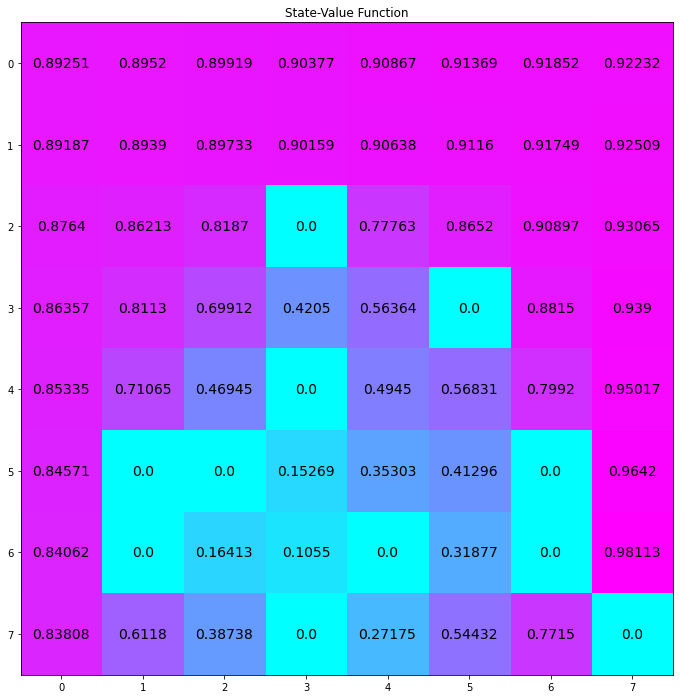

Final Policy: 
[[3 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 2]
 [0 3 0 0 2 3 2 2]
 [0 0 0 1 0 0 2 2]
 [0 3 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 1 0 0 0 0 2]
 [0 1 0 0 1 2 1 0]]
↑ → → → → → → → ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ← ↑ ← ← → ↑ → → ← ← ← ↓ ← ← → → ← ↑ ← ← → ↓ ↑ → ← ← ← ↓ ↑ ← ← → ← ← ↓ ← ← ← ← → ← ↓ ← ← ↓ → ↓ ←


In [52]:
enviorment = gym.make('FrozenLake8x8-v0')
enviorment.render()
tic = time.time()
opt_V, opt_Policy = value_iteration(enviorment.env, max_iteration = 1000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Time to converge: {elapsed_time: 0.3} ms")
print('Optimal Value function: ')
print(opt_V.reshape((8, 8)))
plot_values(opt_V)
print('Final Policy: ')
print(opt_Policy.reshape((8, 8)))
print(' '.join([action_mapping[int(action)] for action in opt_Policy]))

In [0]:
n_episode = 1000
wins, total_reward, avg_reward = play_episodes(enviorment, n_episode, opt_Policy, random = False)

In [41]:
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Total wins with value iteration: 760
Average rewards with value iteration: 0.76


## 4. Solve for Policy Iteration

![](https://github.com/waqasqammar/MDP-with-Value-Iteration-and-Policy-Iteration/blob/master/nb_images/policy_iter.png?raw=1)

In [0]:
def policy_eval(env, policy, V, discount_factor):
    """
    Helper function to evaluate a policy.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to evaluate.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy_value: Estimated value of each state following a given policy and state-value 'V'. 
        
    """
    policy_value = np.zeros(env.nS)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))
            
    return policy_value

In [0]:
def policy_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        new_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize the state-Value function
    V = np.zeros(env.nS)
    
    # intialize a random policy
    policy = np.random.randint(0, 4, env.nS)
    policy_prev = np.copy(policy)
    
    for i in range(max_iteration):
        
        # evaluate given policy
        V = policy_eval(env, policy, V, discount_factor)
        
        # improve policy
        policy = update_policy(env, policy, V, discount_factor)
        
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
                print('policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)
            

            
    return V, policy

## Test Policy Iteration

policy converged at iteration 71
Time to converge:  70.3 ms
Optimal Value function: 
[[0.40875961 0.43455808 0.47192213 0.51276136 0.55345763 0.58988858
  0.61338939 0.62002519]
 [0.40242547 0.42209679 0.4546331  0.49402865 0.53730967 0.58517375
  0.62501946 0.63806161]
 [0.37915896 0.38188305 0.36950109 0.         0.46798198 0.55889155
  0.64109266 0.66814565]
 [0.34312374 0.33222641 0.29514968 0.20311392 0.3250942  0.
  0.64630506 0.71086919]
 [0.29069051 0.26126646 0.18102889 0.         0.31707892 0.40268608
  0.60150278 0.76790616]
 [0.22434922 0.         0.         0.09031574 0.23335748 0.29926665
  0.         0.83715244]
 [0.18064775 0.         0.03361397 0.0405605  0.         0.26842685
  0.         0.91589666]
 [0.15899931 0.10391963 0.0640947  0.         0.25385331 0.50936869
  0.75360343 0.        ]]


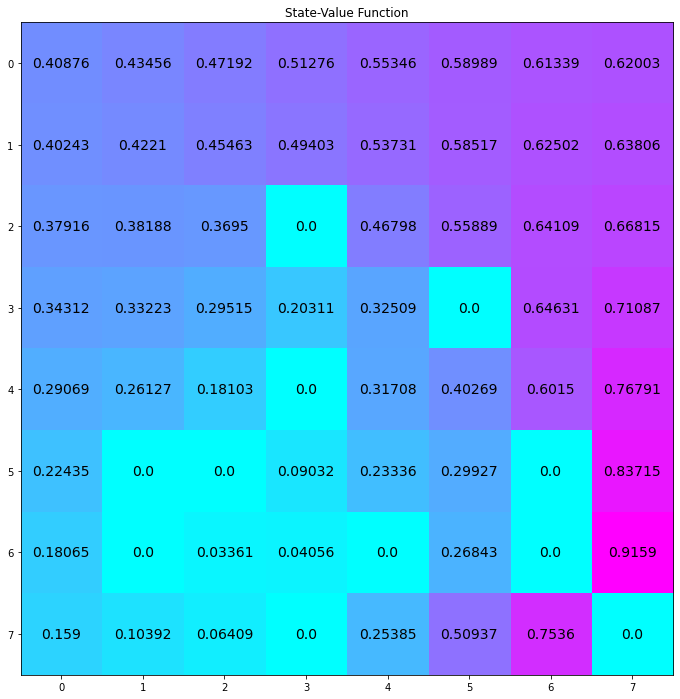

Final Policy: 
[[3 2 2 2 2 2 2 2]
 [3 3 3 3 3 2 2 1]
 [3 3 0 0 2 3 2 1]
 [3 3 3 1 0 0 2 2]
 [3 3 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 1 0 0 0 0 2]
 [0 1 0 0 1 2 1 0]]
↑ → → → → → → → ↑ ↑ ↑ ↑ ↑ → → ↓ ↑ ↑ ← ← → ↑ → ↓ ↑ ↑ ↑ ↓ ← ← → → ↑ ↑ ← ← → ↓ ↑ → ← ← ← ↓ ↑ ← ← → ← ← ↓ ← ← ← ← → ← ↓ ← ← ↓ → ↓ ←


In [51]:
enviorment2 = gym.make('FrozenLake8x8-v0')
tic = time.time()
opt_V2, opt_policy2 = policy_iteration(enviorment2.env, discount_factor = 0.999, max_iteration = 10000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Time to converge: {elapsed_time: 0.3} ms")
print('Optimal Value function: ')
print(opt_V2.reshape((8, 8)))
plot_values(opt_V2)
print('Final Policy: ')
print(opt_policy2.reshape((8,8)))
print(' '.join([action_mapping[(action)] for action in opt_policy2]))

In [0]:
n_episode = 1000
wins, total_reward, avg_reward = play_episodes(enviorment2, n_episode, opt_policy2, random = False)

In [44]:
print(f'Total wins with Policy iteration: {wins}')
print(f"Average rewards with Policy iteration: {avg_reward}")

Total wins with Policy iteration: 736
Average rewards with Policy iteration: 0.736


## Remarks

Policy Iteration converge faster but takes more computation.